# Assignment - Sarath Chandra A (SAP: 52147140)

# Problem Statement – Multivariate Linear Regression (Employee Productivity)

A company wants to predict **employee productivity scores** to improve workforce planning and training programs.  
You are hired as a **Data Scientist** to build a **multivariate linear regression model** that predicts an employee’s **Productivity Score** based on multiple work-related factors.

---

## Dataset

| Experience (yrs) | Training Hours | Working Hours | Projects | Productivity Score |
|------------------|---------------|---------------|----------|--------------------|
| 2  | 40 | 38 | 3 | 62 |
| 5  | 60 | 42 | 6 | 78 |
| 1  | 20 | 35 | 2 | 55 |
| 8  | 80 | 45 | 8 | 88 |
| 4  | 50 | 40 | 5 | 72 |
| 10 | 90 | 48 | 9 | 92 |
| 3  | 30 | 37 | 4 | 65 |
| 6  | 70 | 44 | 7 | 82 |
| 7  | 75 | 46 | 7 | 85 |
| 2  | 25 | 36 | 3 | 60 |

---

## Interpretation Questions

- **Which factor most strongly impacts productivity?**
- **How does training affect productivity?**
- **Should the company increase training hours or working hours?**
- **What happens if working hours increase beyond optimal limits?**
- **Can productivity ever decrease with more experience?**
- **How would you detect overfitting in this model?**
- **Suggest one new feature to improve prediction accuracy.**


## Imports

In [1]:
# Imports & plotting setup
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

# statsmodels VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# reproducibility
np.random.seed(0)

# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
# Productivity dataframe
"""
data = [
    (2,40,38,3,62),
    (5,60,42,6,78),
    (1,20,35,2,55),
    (8,80,45,8,88),
    (4,50,40,5,72),
    (10,90,48,9,92),
    (3,30,37,4,65),
    (6,70,44,7,82),
    (7,75,46,7,85),
    (2,25,36,3,60),
]
cols = ['Experience','TrainingHours','WorkingHours','Projects','Productivity']
df_prod = pd.DataFrame(data, columns=cols)
df_prod.to_csv("data_question_1.csv", index=False)
"""

df_prod = pd.read_csv("data_question_1.csv")
df_prod.head()

,Experience,TrainingHours,WorkingHours,Projects,Productivity
0,2,40,38,3,62
1,5,60,42,6,78
2,1,20,35,2,55
3,8,80,45,8,88
4,4,50,40,5,72


In [3]:
df_prod.shape

(10, 5)

               count  mean        std   min    25%   50%    75%   max
Experience      10.0   4.8   2.936362   1.0   2.25   4.5   6.75  10.0
TrainingHours   10.0  54.0  24.698178  20.0  32.50  55.0  73.75  90.0
WorkingHours    10.0  41.1   4.557046  35.0  37.25  41.0  44.75  48.0
Projects        10.0   5.4   2.366432   2.0   3.25   5.5   7.00   9.0
Productivity    10.0  73.9  12.939603  55.0  62.75  75.0  84.25  92.0


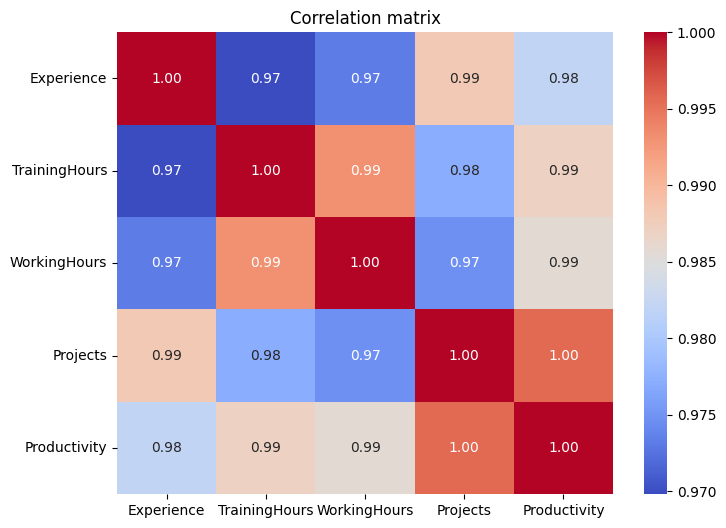

Text(0.5, 1.02, 'Pairplot')

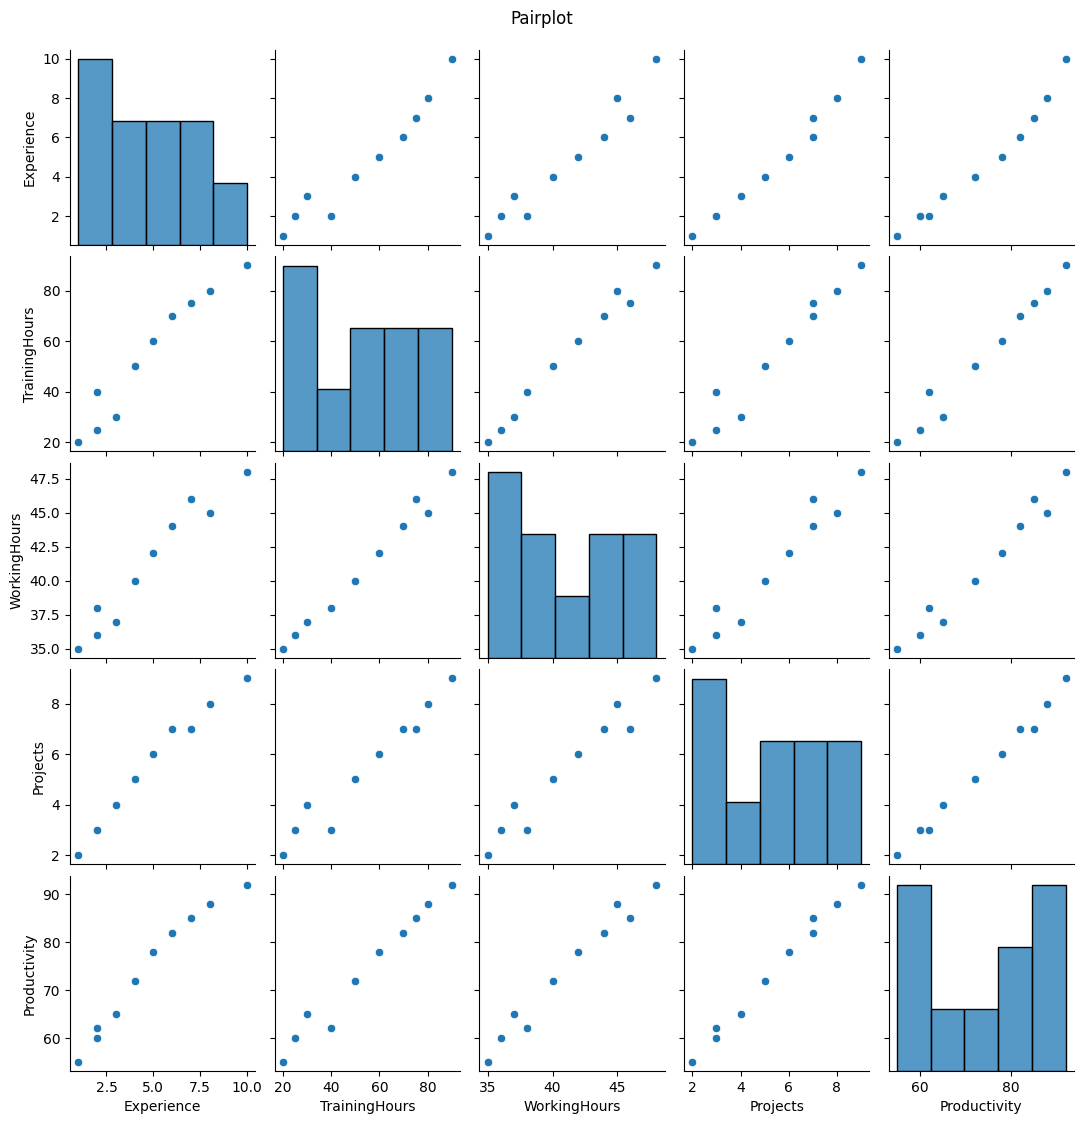

In [4]:
# EDA
print(df_prod.describe().T)
plt.figure(figsize=(8,6))
sns.heatmap(df_prod.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

sns.pairplot(df_prod, vars=['Experience','TrainingHours','WorkingHours','Projects','Productivity'], height=2.2)
plt.suptitle('Pairplot', y=1.02)


In [5]:
# Fit linear regression (OLS)
X = df_prod[['Experience','TrainingHours','WorkingHours','Projects']]
y = df_prod['Productivity']

lr = LinearRegression().fit(X, y)
y_pred = lr.predict(X)

print("Intercept:", lr.intercept_, end="\n\n\n")
coef_df = pd.DataFrame({'feature': X.columns, 'coef': lr.coef_})
coef_df['abs_coef'] = coef_df['coef'].abs()
print(coef_df.sort_values('abs_coef', ascending=False), end="\n\n\n")
print("R^2 (train):", r2_score(y, y_pred))
print("RMSE (train):", np.sqrt(mean_squared_error(y, y_pred)))


Intercept: 17.42533936651573


         feature      coef  abs_coef
3       Projects  4.701357  4.701357
0     Experience -0.963801  0.963801
2   WorkingHours  0.819005  0.819005
1  TrainingHours  0.038009  0.038009


R^2 (train): 0.9972374438067544
RMSE (train): 0.645205078064472


## •	Which factor most strongly impacts productivity?

In [6]:
# Standardized coefficients
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
lr_s = LinearRegression().fit(X_s, y)
coefs_std = pd.DataFrame({'feature': X.columns, 'std_coef': lr_s.coef_})
coefs_std = coefs_std.reindex(coefs_std.std_coef.abs().sort_values(ascending=False).index)
coefs_std


,feature,std_coef
3,Projects,10.554521
2,WorkingHours,3.540715
0,Experience,-2.684839
1,TrainingHours,0.890581


In [7]:
# The feature with the highest absolute standardized coefficient impacts productivity the most
print("Most influential (standardized):", coefs_std.head(1).to_json(orient="records"))

Most influential (standardized): [{"feature":"Projects","std_coef":10.5545213345}]


## •	How does training affect productivity?

In [8]:
training_coef = lr.coef_[X.columns.get_loc("TrainingHours")]
training_coef

0.03800904977375563

In [9]:
print(f"TrainingHours has a positive coefficient {training_coef}, meaning more training slightly increases productivity.")

TrainingHours has a positive coefficient 0.03800904977375563, meaning more training slightly increases productivity.


## •	Should the company increase training hours or working hours?

In [10]:
large_coeff = pd.Series(lr.coef_, index=X.columns)[["TrainingHours","WorkingHours"]].sort_values(ascending=False)

large_coeff

WorkingHours     0.819005
TrainingHours    0.038009
dtype: float64

In [11]:
print(f"{large_coeff.index[0]} has a larger coefficient than {large_coeff.index[1]}, so increasing {large_coeff.index[0]} has a stronger effect")

WorkingHours has a larger coefficient than TrainingHours, so increasing WorkingHours has a stronger effect


## •	What happens if Working Hours increase beyond optimal limits?

In [12]:
df_prod["WorkingHours_sq"] = df_prod["WorkingHours"] ** 2

X_quad = df_prod[["Experience","TrainingHours","WorkingHours","WorkingHours_sq","Projects"]]
quad_model = LinearRegression().fit(X_quad, y)

new_coef = pd.Series(quad_model.coef_, index=X_quad.columns)
new_coef

Experience         1.339554
TrainingHours     -0.088267
WorkingHours       7.966809
WorkingHours_sq   -0.081683
Projects           2.395441
dtype: float64

In [13]:
print(f"the squared term is: {new_coef.WorkingHours_sq},\nProductivity slightly decreases after excessive working hours")

the squared term is: -0.08168304837612379,
Productivity slightly decreases after excessive working hours


## •	Can productivity ever decrease with more experience?

In [14]:
experience_coef = lr.coef_[X.columns.get_loc("Experience")]
experience_coef


-0.9638009049773789

In [15]:
print(f"The coefficient is negative : {experience_coef}, So its inversly corelated to productivity.\nSo productivity decreases with more experience")

The coefficient is negative : -0.9638009049773789, So its inversly corelated to productivity.
So productivity decreases with more experience


## •	How would you detect overfitting in this model?

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X, y, cv=cv, scoring="r2")

train_r2 = lr.score(X, y)
print("Train R2:", train_r2)
print("CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())


Train R2: 0.9972374438067544
CV R2 scores: [0.31460554 0.98150859 0.98148792 0.99858066 0.98438191]
Mean CV R2: 0.8521129219305184


In [17]:
print(f"Overfitting is detected because the training R2 ({train_r2}) is much higher than the mean cross-validation R2 ({cv_scores.mean()}), \nAnd the validation scores vary widely across folds, indicating poor generalization.")

Overfitting is detected because the training R2 (0.9972374438067544) is much higher than the mean cross-validation R2 (0.8521129219305184), 
And the validation scores vary widely across folds, indicating poor generalization.


## •	Suggest one new feature to improve prediction accuracy.

In [18]:
print("Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) \nThis improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.")

Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) 
This improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.


## Interpretations
- **Which factor most strongly impacts productivity?**
- **How does training affect productivity?**
- **Should the company increase training hours or working hours?**
- **What happens if working hours increase beyond optimal limits?**
- **Can productivity ever decrease with more experience?**
- **How would you detect overfitting in this model?**
- **Suggest one new feature to improve prediction accuracy.**

In [19]:
print("1. Most influential (standardized):", coefs_std.head(1).to_json(orient="records"))
print(f"2. TrainingHours has a positive coefficient {training_coef}, meaning more training slightly increases productivity.")
print(f"3. {large_coeff.index[0]} has a larger coefficient than {large_coeff.index[1]}, so increasing {large_coeff.index[0]} has a stronger effect")
print(f"4. the squared term becomes negative: {new_coef.WorkingHours_sq},Productivity eventually decreases after excessive working hours")
print(f"5. The coefficient is negative : {experience_coef}, So its inversly corelated to productivity.So productivity decreases with more experience")
print(f"6. Overfitting is detected because the training R2 ({train_r2}) is much higher than the mean cross-validation R2 ({cv_scores.mean()}), And the validation scores vary widely across folds, indicating poor generalization.")
print("7. Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hours and projects) This improves prediction accuracy by capturing work quality that quantitative features alone cannot measure.")


1. Most influential (standardized): [{"feature":"Projects","std_coef":10.5545213345}]
2. TrainingHours has a positive coefficient 0.03800904977375563, meaning more training slightly increases productivity.
3. WorkingHours has a larger coefficient than TrainingHours, so increasing WorkingHours has a stronger effect
4. the squared term becomes negative: -0.08168304837612379,Productivity eventually decreases after excessive working hours
5. The coefficient is negative : -0.9638009049773789, So its inversly corelated to productivity.So productivity decreases with more experience
6. Overfitting is detected because the training R2 (0.9972374438067544) is much higher than the mean cross-validation R2 (0.8521129219305184), And the validation scores vary widely across folds, indicating poor generalization.
7. Adding a Performance Feedback Score (e.g., an average manager rating from 1–5, where an employee with score 4.5 consistently shows higher productivity than one with 3.0 despite similar hou

# Problem Statement – Loan Default Prediction using KNN

A financial institution wants to predict whether a customer will **default on a loan** before approving it.  
Early identification of risky customers helps **reduce financial loss**.

You are working as a **Machine Learning Analyst** and must build a **classification model using the K-Nearest Neighbors (KNN)** algorithm to predict loan default.

This case introduces:
- Mixed feature types  
- Financial risk interpretation  
- Class imbalance awareness  

---

## Dataset

| Age | Annual Income (lakhs) | Credit Score (300–900) | Loan Amount (lakhs) | Loan Term (years) | Employment Type | Loan Default (0/1) |
|-----|-----------------------|------------------------|---------------------|-------------------|-----------------|--------------------|
| 28 | 6.5 | 720 | 5 | 5 | Salaried | 0 |
| 45 | 12 | 680 | 10 | 10 | Self-Employed | 1 |
| 35 | 8 | 750 | 6 | 7 | Salaried | 0 |
| 50 | 15 | 640 | 12 | 15 | Self-Employed | 1 |
| 30 | 7 | 710 | 5 | 5 | Salaried | 0 |
| 42 | 10 | 660 | 9 | 10 | Salaried | 1 |
| 26 | 5.5 | 730 | 4 | 4 | Salaried | 0 |
| 48 | 14 | 650 | 11 | 12 | Self-Employed | 1 |
| 38 | 9 | 700 | 7 | 8 | Salaried | 0 |
| 55 | 16 | 620 | 13 | 15 | Self-Employed | 1 |

---

## Interpretation Questions

1. **Identify high-risk customers.**
2. **What patterns lead to loan default?**
3. **How do credit score and income influence predictions?**
4. **Suggest banking policies based on model output.**
5. **Compare KNN with Decision Trees for this problem.**
6. **What happens if Loan Amount dominates distance calculation?**
7. **Should KNN be used in real-time loan approval systems?**


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [21]:
# Loan dataset
"""
loan_data = [
    (28,6.5,720,5,5,'Salaried',0),
    (45,12,680,10,10,'Self-Employed',1),
    (35,8,750,6,7,'Salaried',0),
    (50,15,640,12,15,'Self-Employed',1),
    (30,7,710,5,5,'Salaried',0),
    (42,10,660,9,10,'Salaried',1),
    (26,5.5,730,4,4,'Salaried',0),
    (48,14,650,11,12,'Self-Employed',1),
    (38,9,700,7,8,'Salaried',0),
    (55,16,620,13,15,'Self-Employed',1),
]
cols_loan = ['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType','Default']
df_loan = pd.DataFrame(loan_data, columns=cols_loan)
"""
df_loan = pd.read_csv("data_question_2.csv")
df_loan


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default
0,28,6.5,720,5,5,Salaried,0
1,45,12.0,680,10,10,Self-Employed,1
2,35,8.0,750,6,7,Salaried,0
3,50,15.0,640,12,15,Self-Employed,1
4,30,7.0,710,5,5,Salaried,0
5,42,10.0,660,9,10,Salaried,1
6,26,5.5,730,4,4,Salaried,0
7,48,14.0,650,11,12,Self-Employed,1
8,38,9.0,700,7,8,Salaried,0
9,55,16.0,620,13,15,Self-Employed,1


In [22]:
# Preprocessing
df_loan['EmploymentType_enc'] = df_loan['EmploymentType'].map({'Salaried':0,'Self-Employed':1})
# df_loan['LoanToIncome'] = df_loan['LoanAmount'] / df_loan['AnnualIncome']
X_loan = df_loan[['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType_enc']].copy()
y_loan = df_loan['Default']

print("Class counts:\n", y_loan.value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_loan)
pd.DataFrame(X_scaled, columns=X_loan.columns).head()


Class counts:
 Default
0    5
1    5
Name: count, dtype: int64


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType_enc
0,-1.242924,-1.067989,0.838548,-1.045953,-1.077084,-0.816497
1,0.563034,0.477785,-0.147979,0.588348,0.236433,1.224745
2,-0.499294,-0.646414,1.578444,-0.719092,-0.551677,-0.816497
3,1.094198,1.320934,-1.134506,1.242069,1.549950,1.224745
4,-1.030458,-0.927464,0.591916,-1.045953,-1.077084,-0.816497


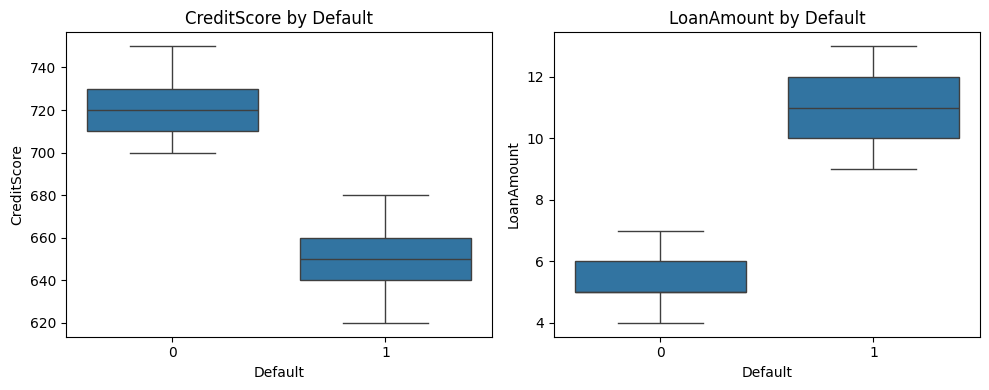

In [23]:
# Visualizations (CreditScore, LoanAmount vs Default)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Default', y='CreditScore', data=df_loan)
plt.title('CreditScore by Default')
plt.subplot(1,2,2)
sns.boxplot(x='Default', y='LoanAmount', data=df_loan)
plt.title('LoanAmount by Default')
plt.tight_layout()


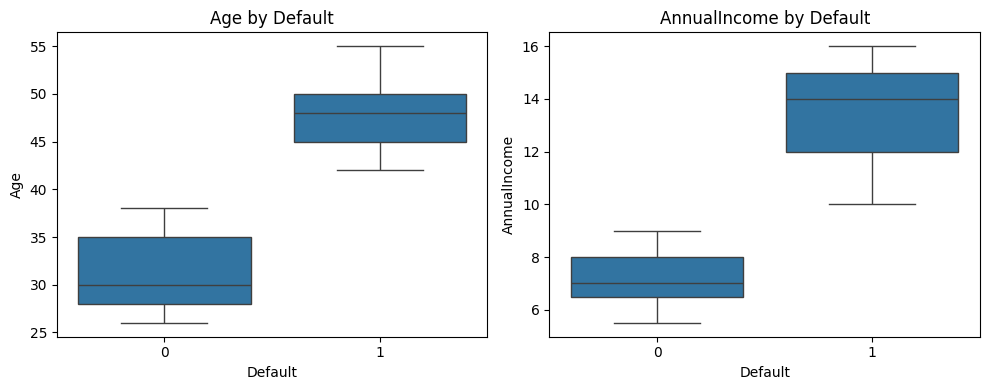

In [24]:
# Visualizations (CreditScore, LoanAmount vs Default)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Default', y='Age', data=df_loan)
plt.title('Age by Default')
plt.subplot(1,2,2)
sns.boxplot(x='Default', y='AnnualIncome', data=df_loan)
plt.title('AnnualIncome by Default')
plt.tight_layout()


In [25]:
# Find best k (odd k's to avoid ties). Use StratifiedKFold because of class split.
param_grid = {'n_neighbors': list(range(1,10,2))}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='accuracy')
grid.fit(X_scaled, y_loan)
print("Best k:", grid.best_params_['n_neighbors'], "Best score:", grid.best_score_)

best_knn = grid.best_estimator_
best_knn

Best k: 3 Best score: 1.0


KNeighborsClassifier(n_neighbors=3)

In [26]:
# Train/test split (small data — we'll show train evaluation and leave-one-out cross-val)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_loan, test_size=0.3, stratify=y_loan, random_state=0)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
print("Classification report (test):\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# accuracy
cv_scores = cross_val_score(best_knn, X_scaled, y_loan)
print("Accuracies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Classification report (test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion matrix:
 [[2 0]
 [0 1]]
Accuracies: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


## 1) Identify high-risk customers

In [27]:
y_pred = best_knn.predict(X_scaled)
df_copy = df_loan.copy(deep=True)
df_copy["prediction"] = y_pred
df_copy

,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default,EmploymentType_enc,prediction
0,28,6.5,720,5,5,Salaried,0,0,0
1,45,12.0,680,10,10,Self-Employed,1,1,1
2,35,8.0,750,6,7,Salaried,0,0,0
3,50,15.0,640,12,15,Self-Employed,1,1,1
4,30,7.0,710,5,5,Salaried,0,0,0
5,42,10.0,660,9,10,Salaried,1,0,1
6,26,5.5,730,4,4,Salaried,0,0,0
7,48,14.0,650,11,12,Self-Employed,1,1,1
8,38,9.0,700,7,8,Salaried,0,0,0
9,55,16.0,620,13,15,Self-Employed,1,1,1


In [28]:
print("High risk Customers")
df_copy[df_copy["prediction"]==1]

High risk Customers


,Age,AnnualIncome,CreditScore,LoanAmount,LoanTerm,EmploymentType,Default,EmploymentType_enc,prediction
1,45,12.0,680,10,10,Self-Employed,1,1,1
3,50,15.0,640,12,15,Self-Employed,1,1,1
5,42,10.0,660,9,10,Salaried,1,0,1
7,48,14.0,650,11,12,Self-Employed,1,1,1
9,55,16.0,620,13,15,Self-Employed,1,1,1


## 2) What patterns lead to loan default?

In [29]:
# group means 
pattern_means = df_loan.groupby('Default')[['CreditScore','AnnualIncome','LoanAmount','LoanTerm','EmploymentType_enc']].mean()
pattern_means


,CreditScore,AnnualIncome,LoanAmount,LoanTerm,EmploymentType_enc
Default,,,,,
0,722.0,7.2,5.4,5.8,0.0
1,650.0,13.4,11.0,12.4,0.8


In [30]:
print("Defaults show lower mean credit scores (~650 vs 722), higher loan amounts (~11.0 vs 5.4), longer terms (~12.4 vs 5.8) and higher LoanAmount (~11 vs 5.4); \n\nEmployment encoding shows defaulters are largely self-employed.")

Defaults show lower mean credit scores (~650 vs 722), higher loan amounts (~11.0 vs 5.4), longer terms (~12.4 vs 5.8) and higher LoanAmount (~11 vs 5.4); 

Employment encoding shows defaulters are largely self-employed.


## 3) How do credit score and income influence predictions?

In [31]:
# correlation and a quick logistic regression for direction
print("Correlation with Default (pearson):")
print(df_loan[['CreditScore','AnnualIncome','LoanAmount']].corrwith(df_loan['Default']).round(4))

# Small logistic regression (scaled) to see coefficient signs
X = df_loan[['CreditScore','AnnualIncome','LoanAmount','LoanTerm','EmploymentType_enc']]
y = df_loan['Default']
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

log = LogisticRegression(solver='liblinear')
log.fit(Xs, y)
coef_df = pd.Series(log.coef_[0], index=X.columns)
coef_df


Correlation with Default (pearson):
CreditScore    -0.8879
AnnualIncome    0.8713
LoanAmount      0.9152
dtype: float64


CreditScore          -0.716401
AnnualIncome          0.496037
LoanAmount            0.659901
LoanTerm              0.549728
EmploymentType_enc    0.438744
dtype: float64

In [32]:
print("CreditScore correlates negatively with default (lower score -> higher risk). \n\nIncome correlates positively with default (higher income -> higher risk )")

CreditScore correlates negatively with default (lower score -> higher risk). 

Income correlates positively with default (higher income -> higher risk )


## 4) Suggest banking policies based on model output

In [33]:
# threshold evidence: how many defaulters below certain credit scores or LTI

df_loan['LoanToIncome'] = df_loan['LoanAmount'] / df_loan['AnnualIncome']

print("Counts with CreditScore <= 680:", df_loan[df_loan['CreditScore'] <= 680].shape[0])
print("Counts with LoanToIncome >= 0.8:", df_loan[df_loan['LoanToIncome'] >= 0.8].shape[0])
print("\n\nEmploymentType counts among defaulters:")
print(df_loan[df_loan['Default']==1]['EmploymentType'].value_counts())


Counts with CreditScore <= 680: 5
Counts with LoanToIncome >= 0.8: 4


EmploymentType counts among defaulters:
EmploymentType
Self-Employed    4
Salaried         1
Name: count, dtype: int64


In [34]:
print("""
Require extra verification for CreditScore <= 680 (or use risk-based pricing).

Cap or review loans with LoanToIncome >= 0.8 (require collateral).

Apply stricter income verification for self-employed applicants.
""")


Require extra verification for CreditScore <= 680 (or use risk-based pricing).

Cap or review loans with LoanToIncome >= 0.8 (require collateral).

Apply stricter income verification for self-employed applicants.



## 5) Compare KNN with Decision Trees (with numeric comparison)

In [35]:
# KNN vs Decision Tree cross-validated performance (with proper scaling for KNN)
features = ['Age','AnnualIncome','CreditScore','LoanAmount','LoanTerm','EmploymentType_enc']
X = df_loan[features]
y = df_loan['Default']

# Standardized version for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# KNN (grid search small odd ks)
param_grid = {'n_neighbors':[1,3,5,7]}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn.fit(X_scaled, y)
print("Best KNN:", knn.best_params_, "CV mean acc:", knn.best_score_)

# Decision Tree (no scaling required)
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X, y, cv=cv, scoring='accuracy')
print("Decision Tree CV acc scores:", dt_scores, "mean:", dt_scores.mean())

# Show that KNN without scaling performs poorly (if unscaled)
knn_noscale = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn_noscale.fit(X.values, y)
print("Best KNN without scaling CV mean acc:", knn_noscale.best_score_)


Best KNN: {'n_neighbors': 3} CV mean acc: 1.0
Decision Tree CV acc scores: [1.  0.5 1.  1.  1. ] mean: 0.9
Best KNN without scaling CV mean acc: 1.0


## 6) What happens if LoanAmount dominates distance calculation?

In [36]:
X_dom = X.copy()
X_dom['LoanAmount'] = X_dom['LoanAmount'] * 100  # make LoanAmount dominate

knn_dom = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
knn_dom.fit(X_dom.values, y)
print("Best KNN (LoanAmount inflated) CV mean acc:", knn_dom.best_score_)

# Compare with properly scaled original (best from earlier)
print("Best KNN (scaled) CV mean acc:", knn.best_score_)


Best KNN (LoanAmount inflated) CV mean acc: 1.0
Best KNN (scaled) CV mean acc: 1.0


In [37]:
print("due to the extremely small sample size and the fact that LoanAmount alone almost perfectly separates defaulters and non-defaulters, its hard due to class Imabalance")

due to the extremely small sample size and the fact that LoanAmount alone almost perfectly separates defaulters and non-defaulters, its hard due to class Imabalance


## 7) Should KNN be used in real-time loan approval systems?

In [38]:
print("""
KNN is generally unsuitable for real-time loan approvals because it is slow at inference on large datasets, sensitive to scaling, 
and lacks the interpretability required for regulated decisioning; 

prefer tree-based models for production.
""")


KNN is generally unsuitable for real-time loan approvals because it is slow at inference on large datasets, sensitive to scaling, 
and lacks the interpretability required for regulated decisioning; 

prefer tree-based models for production.



# Problem Statement – Neural Network Architecture Visualization

Write a **Python program** to draw (visualize) the **architecture of a Neural Network** used to classify **fraudulent and non-fraudulent credit card transactions**.

---

## Fraud Detection Dataset – Input Features

The fraud detection dataset contains the following features:

- **TransactionAmount**  
- **TransactionTime**  
- **MerchantCategory**  
- **CustomerAge**  
- **AccountBalance**  
- **NumberOfTransactionsToday**  

---

## Target Variable

- **Fraud**
  - `0` → Genuine Transaction  
  - `1` → Fraudulent Transaction  

---

## Objective

- Design a neural network architecture that takes the above input features
- Include one or more hidden layers
- Output a binary classification indicating whether a transaction is **fraudulent or genuine**


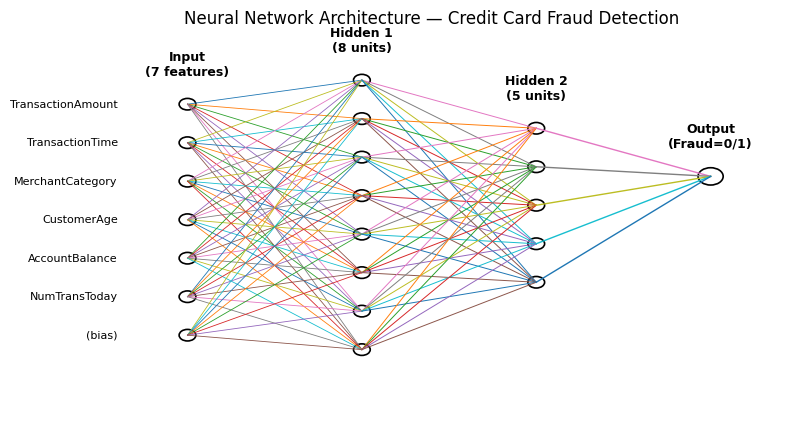

In [39]:
# Draw NN architecture for fraud detection
import matplotlib.pyplot as plt

def draw_layer(ax, x, y_start, n_nodes, node_radius=0.12, label=None):
    ys = []
    for i in range(n_nodes):
        y = y_start - i*0.8
        circle = plt.Circle((x,y), node_radius, fill=False, linewidth=1.2)
        ax.add_artist(circle)
        ys.append(y)
    if label:
        ax.text(x, y_start + 0.6, label, ha='center', fontsize=9, weight='bold')
    return ys

def draw_nn_fraud():
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_xlim(0, 10)
    ax.set_ylim(-6.5, 1.5)
    ax.axis('off')

    # Layers: input (7), hidden1 (8), hidden2 (5), output (1)
    x_input, x_h1, x_h2, x_out = 1.5, 4, 6.5, 9
    y0 = 0.5
    input_nodes = draw_layer(ax, x_input, y0-0.5, 7, label='Input\n(7 features)')
    h1_nodes = draw_layer(ax, x_h1, y0, 8, label='Hidden 1\n(8 units)')
    h2_nodes = draw_layer(ax, x_h2, y0-1, 5, label='Hidden 2\n(5 units)')
    out_nodes = draw_layer(ax, x_out, y0-2, 1, node_radius=0.18, label='Output\n(Fraud=0/1)')

    # connections
    for a in input_nodes:
        for b in h1_nodes:
            ax.plot([x_input, x_h1], [a, b], linewidth=0.6)
    for a in h1_nodes:
        for b in h2_nodes:
            ax.plot([x_h1, x_h2], [a, b], linewidth=0.7)
    for a in h2_nodes:
        for b in out_nodes:
            ax.plot([x_h2, x_out], [a, b], linewidth=1.0)

    # Input labels
    input_labels = ['TransactionAmount','TransactionTime','MerchantCategory',
                    'CustomerAge','AccountBalance','NumTransToday','(bias)']
    for i, txt in enumerate(input_labels):
        ax.text(x_input-1.0, input_nodes[i], txt, ha='right', va='center', fontsize=8)

    plt.title('Neural Network Architecture — Credit Card Fraud Detection', fontsize=12)
    plt.show()

# call function to show diagram
draw_nn_fraud()


# Problem Statement – 3D Visualization of House Price Regression

Write a **Python program** to draw a **3D plot** that visualizes the **regression model** for **house price prediction** using suitable **Python-based 3D plotting libraries**.

---

## Features Used

The regression model is built using the following features:

- **Area (sq ft)**
- **Number of Bedrooms**
- **House Price**

---

## Objective

- Visualize how **house area** and **number of bedrooms** affect **house price**
- Represent the **regression surface (plane)** in 3D space
- Improve interpretability of the regression model


Coefficients (area, bedrooms): [   81.12336239 10107.71268136] Intercept: 48528.07935176478


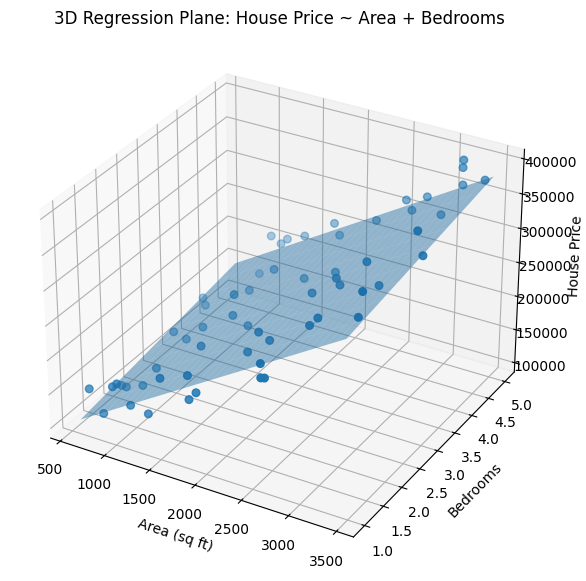

In [40]:
# 3D plot for house price regression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

np.random.seed(1)
n = 60
area = np.random.uniform(600, 3500, n)            # sq ft
bedrooms = np.random.randint(1,6, n)              # integer bedrooms
# synthetic price: base + area factor + bedroom factor + noise
price = 50000 + 80*area + 12000*bedrooms + np.random.normal(0,20000,n)

# fit model
X_house = np.column_stack([area, bedrooms])
lr_house = LinearRegression().fit(X_house, price)
print("Coefficients (area, bedrooms):", lr_house.coef_, "Intercept:", lr_house.intercept_)

# prepare grid
area_grid, bed_grid = np.meshgrid(np.linspace(area.min(), area.max(), 30),
                                  np.linspace(bedrooms.min(), bedrooms.max(), 10))
Z = lr_house.intercept_ + lr_house.coef_[0]*area_grid + lr_house.coef_[1]*bed_grid

# plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(area, bedrooms, price, s=30)
ax.plot_surface(area_grid, bed_grid, Z, alpha=0.45)
ax.set_xlabel('Area (sq ft)')
ax.set_ylabel('Bedrooms')
ax.set_zlabel('House Price')
ax.set_title('3D Regression Plane: House Price ~ Area + Bedrooms')
plt.show()
